In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pymc3 as pm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
import patsy

In [4]:
heart = pd.read_csv('/Users/tlee010/desktop/DSI-SF-2-timdavidlee/datasets/heart_disease/heart_disease.csv')

In [5]:
heart.sex.unique()

array([1, 0])

In [6]:
heart.age.describe()

count    303.000000
mean      54.438944
std        9.038662
min       29.000000
25%       48.000000
50%       56.000000
75%       61.000000
max       77.000000
Name: age, dtype: float64

In [10]:
X = heart[['age','sex']]
y= heart.chol.values

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11888be10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x118e3a690>], dtype=object)

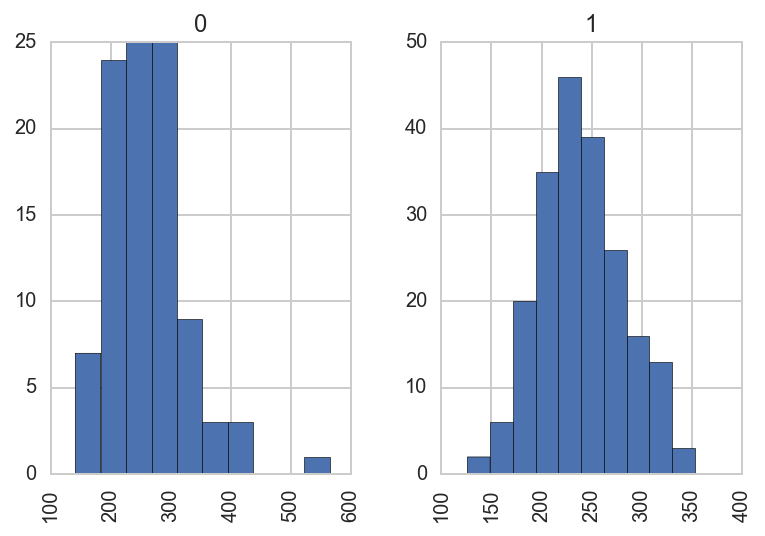

In [12]:
heart.hist(column='chol', by='sex')

In [16]:
# by gender 
linreg = LinearRegression()
linreg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
print linreg.intercept_
print linreg.coef_

200.700171194
[  1.0956676  -20.08344167]


In [19]:
# now bayesian


with pm.Model() as chol_simple:
    family= pm.glm.families.Normal()
    # this is the standard for regressions - the outcome is normally distributed. 
    # we are going to model it as a normally distributed model
    # can have binomial, poissons, logit, etc. 
    # can have different options
    # glm = generalized linear model
    # called a link function - allows us to model a 
    # poissons - counts of things that happen over time --- 
    # - cant model count with a standard regression (cant have a negative count)
    pm.glm.glm('chol ~ sex + age',heart, family=family)

Applied log-transform to sd and added transformed sd_log_ to model.


In [21]:
with chol_simple:
    step = pm.Metropolis()
    chol_trace = pm.sample(100000,step, progressbar = True)

 [-----------------100%-----------------] 100000 of 100000 complete in 30.7 sec

In [23]:
#posterior
'''
P(age-beta | data )
=
P(data|age-beta)
---------------- P(age-beta)
P(data)


We have data, we make one model, and it may be close, but may not be.
We will go through multiple models--- 

Compare:
model1
-------
model2

'''

'\nP(age-beta | data )\n=\nP(data|age-beta)\n---------------- P(age-beta)\nP(data)\n\n\nWe have data, we make one model, and it may be close, but may not be.\nWe will go through multiple models--- \n\nCompare:\nmodel1\n-------\nmodel2\n\n'

In [24]:
# tale 2nd half of the trace, which is the MCMC samples for the
# different distributions. Cutting off the initail portion is good
# because it is often landing on the bad / weird ones ta the beginning


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1199cf1d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11a16b8d0>]], dtype=object)

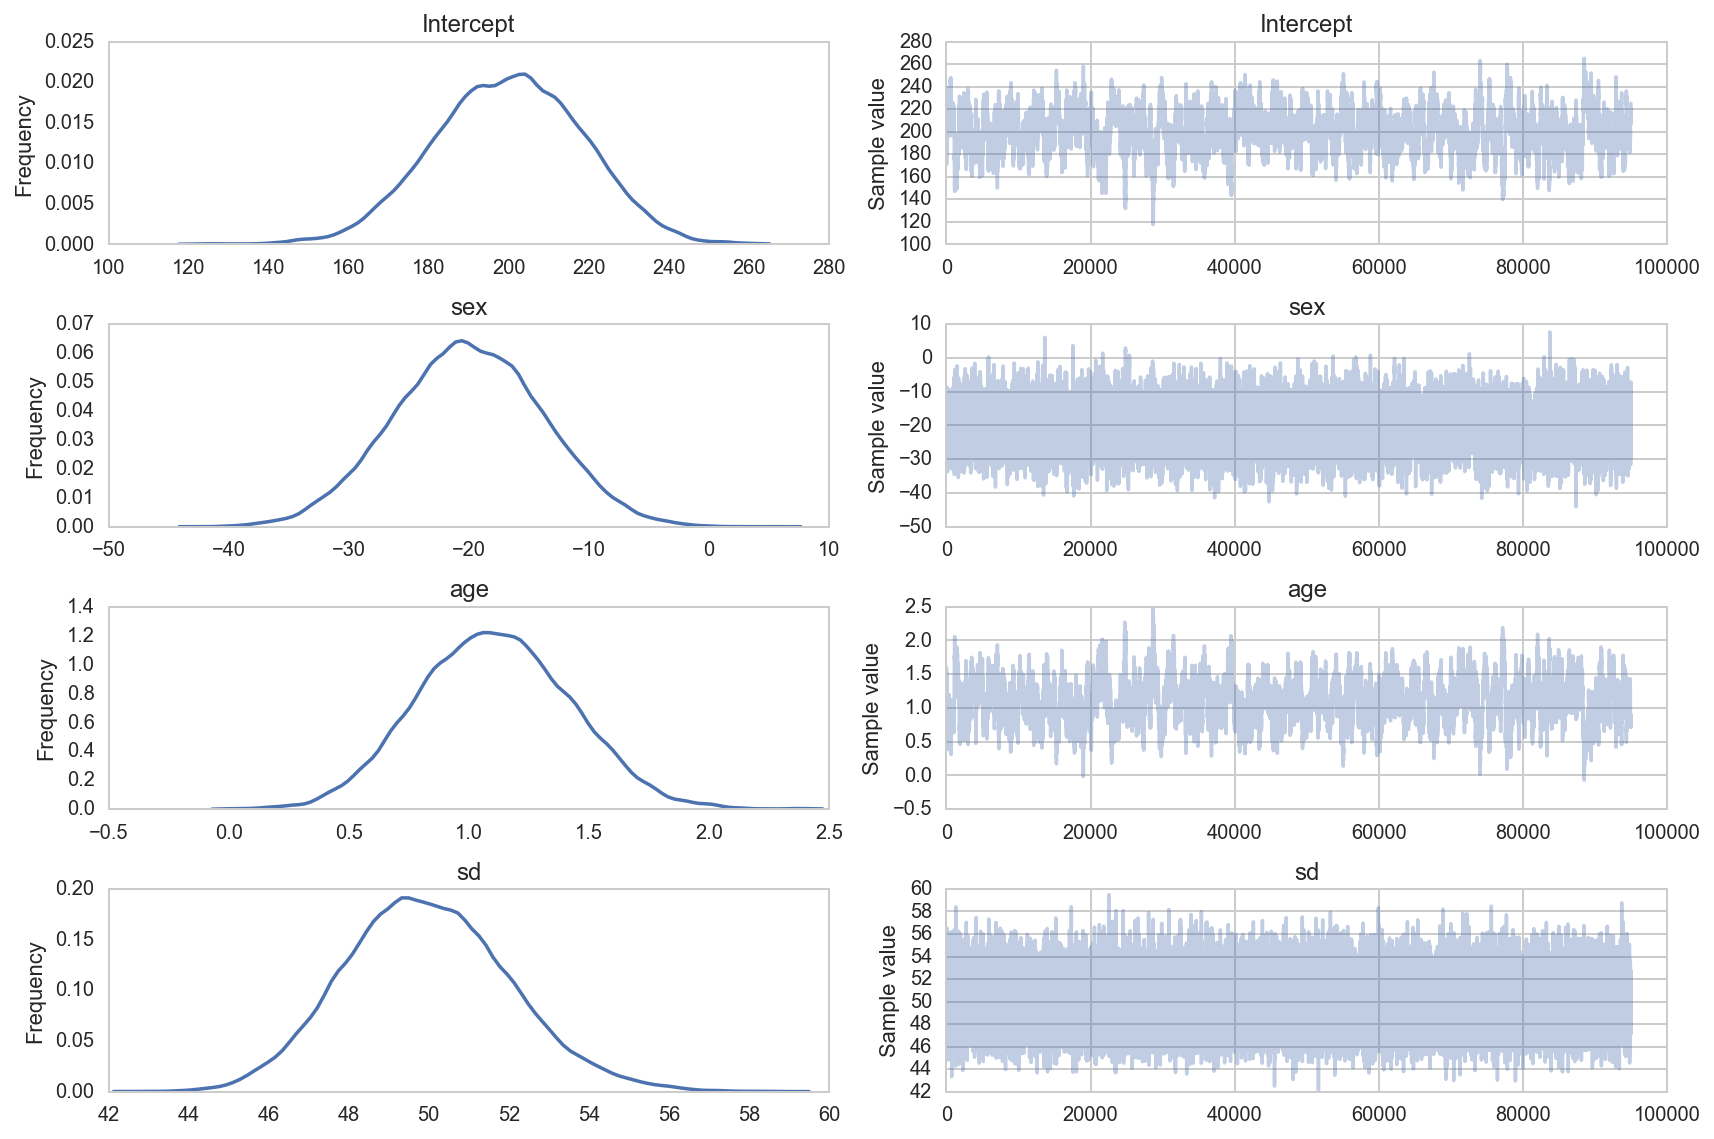

In [30]:
pm.traceplot(chol_trace[5000:])
#max - get very close to scikit learn -- we have fed it uninformed prior beliefs
#getting close to 'i believe nothign at all, build it all on the current updated data'

array([<matplotlib.axes._subplots.AxesSubplot object at 0x118af0f90>], dtype=object)

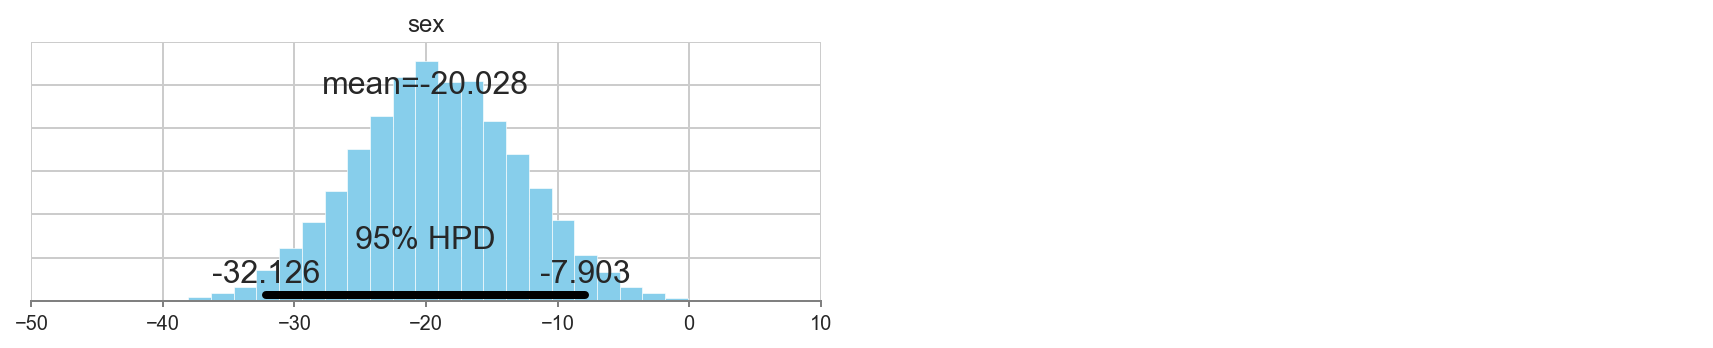

In [32]:
pm.plot_posterior(chol_trace[50000:],varnames=['sex'],color='#87ceeb')
# histogram
# this is a histogram of all the coefficients ---
# if it lands on zero, it may not have any effect on the predictive models

array([<matplotlib.axes._subplots.AxesSubplot object at 0x121f700d0>], dtype=object)

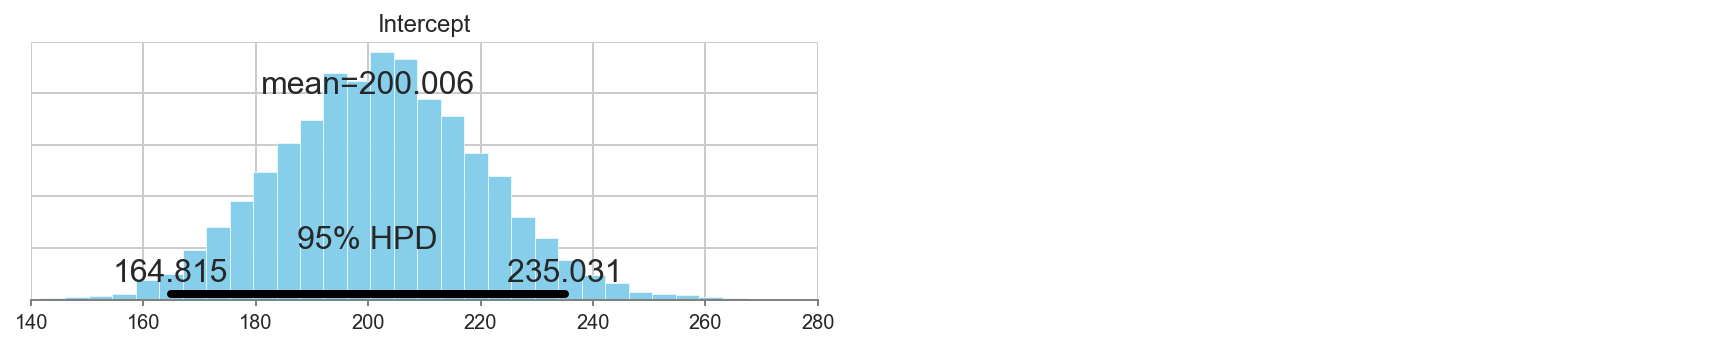

In [34]:
pm.plot_posterior(chol_trace[50000:],varnames=['Intercept'],color='#87ceeb')


In [37]:
#confidence interval - its 2 numbers, its not a distribution,
#not a distribution like what we have above

ppc = pm.sample_ppc(chol_trace[50000:], samples = 10, model = chol_simple)

(array([  3.,   9.,  19.,  53.,  55.,  51.,  42.,  27.,  25.,  11.,   3.,
          0.,   3.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 126. ,  147.9,  169.8,  191.7,  213.6,  235.5,  257.4,  279.3,
         301.2,  323.1,  345. ,  366.9,  388.8,  410.7,  432.6,  454.5,
         476.4,  498.3,  520.2,  542.1,  564. ]),
 <a list of 20 Patch objects>)

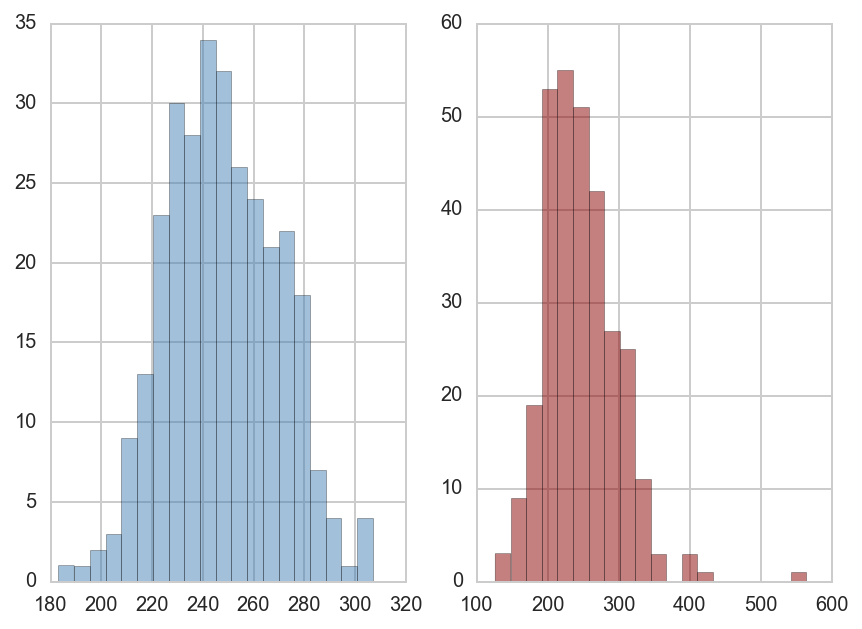

In [50]:
ppc['y'].shape
y_hat = np.mean(ppc['y'],axis=0)[0]

fig, ax = plt.subplots(1,2,figsize=(7,5))
ax[0].hist(y_hat,bins=20,color='steelblue',alpha=0.5)
ax[1].hist(heart.chol.values,bins=20,color='darkred',alpha=0.5)

In [40]:
heart.shape

(303, 14)

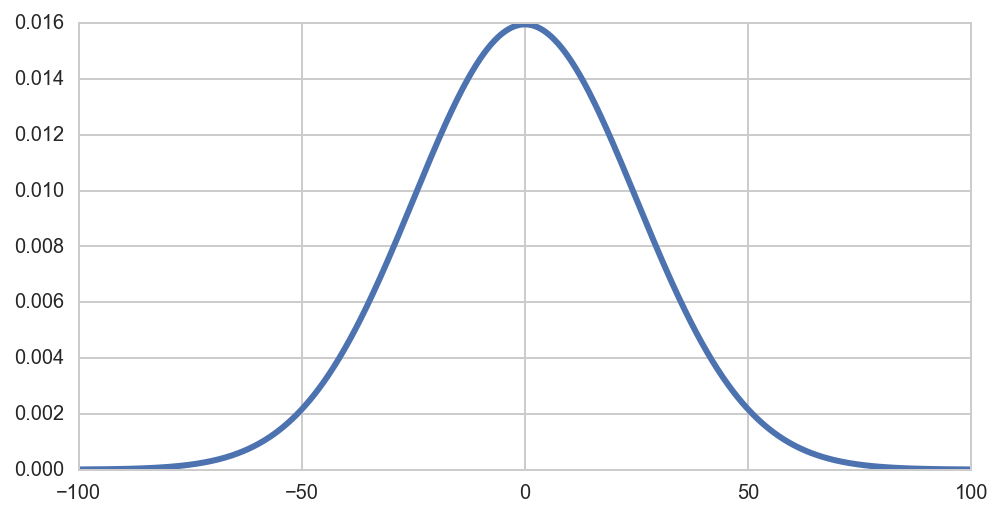

In [59]:
import scipy.stats as stats
int_pdf = stats.norm(loc=0, scale=25)
x_vals = np.linspace(-100, 100, 1000)
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x_vals, int_pdf.pdf(x_vals),lw=3)
plt.show()
# this is a weak prior

In [81]:
#================================================================
# this is the long way

with pm.Model() as chol_manual:
    intercept = pm.Normal('intercept', mu=0, sd=10000.)
    age_coef =pm.Normal('male_coef',mu=0, sd=10000.)
    sex_coef = pm.Normal('sex_coef',mu=0,sd =10000.)
    chol_est = intercept + sex_coef*heart.sex.values + age_coef*heart.age.values
    model_error = pm.Uniform('model_error', lower=0, upper=1000000.)
    
    chol_likelihood = pm.Normal('chol_like',mu=chol_est, sd=model_error, observed=heart.chol.values)

Applied interval-transform to model_error and added transformed model_error_interval_ to model.


In [82]:
with chol_manual:
    step = pm.Metropolis()
    trace = pm.sample(50000,step)

 [-----------------100%-----------------] 50000 of 50000 complete in 15.3 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128d88710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12bb40050>]], dtype=object)

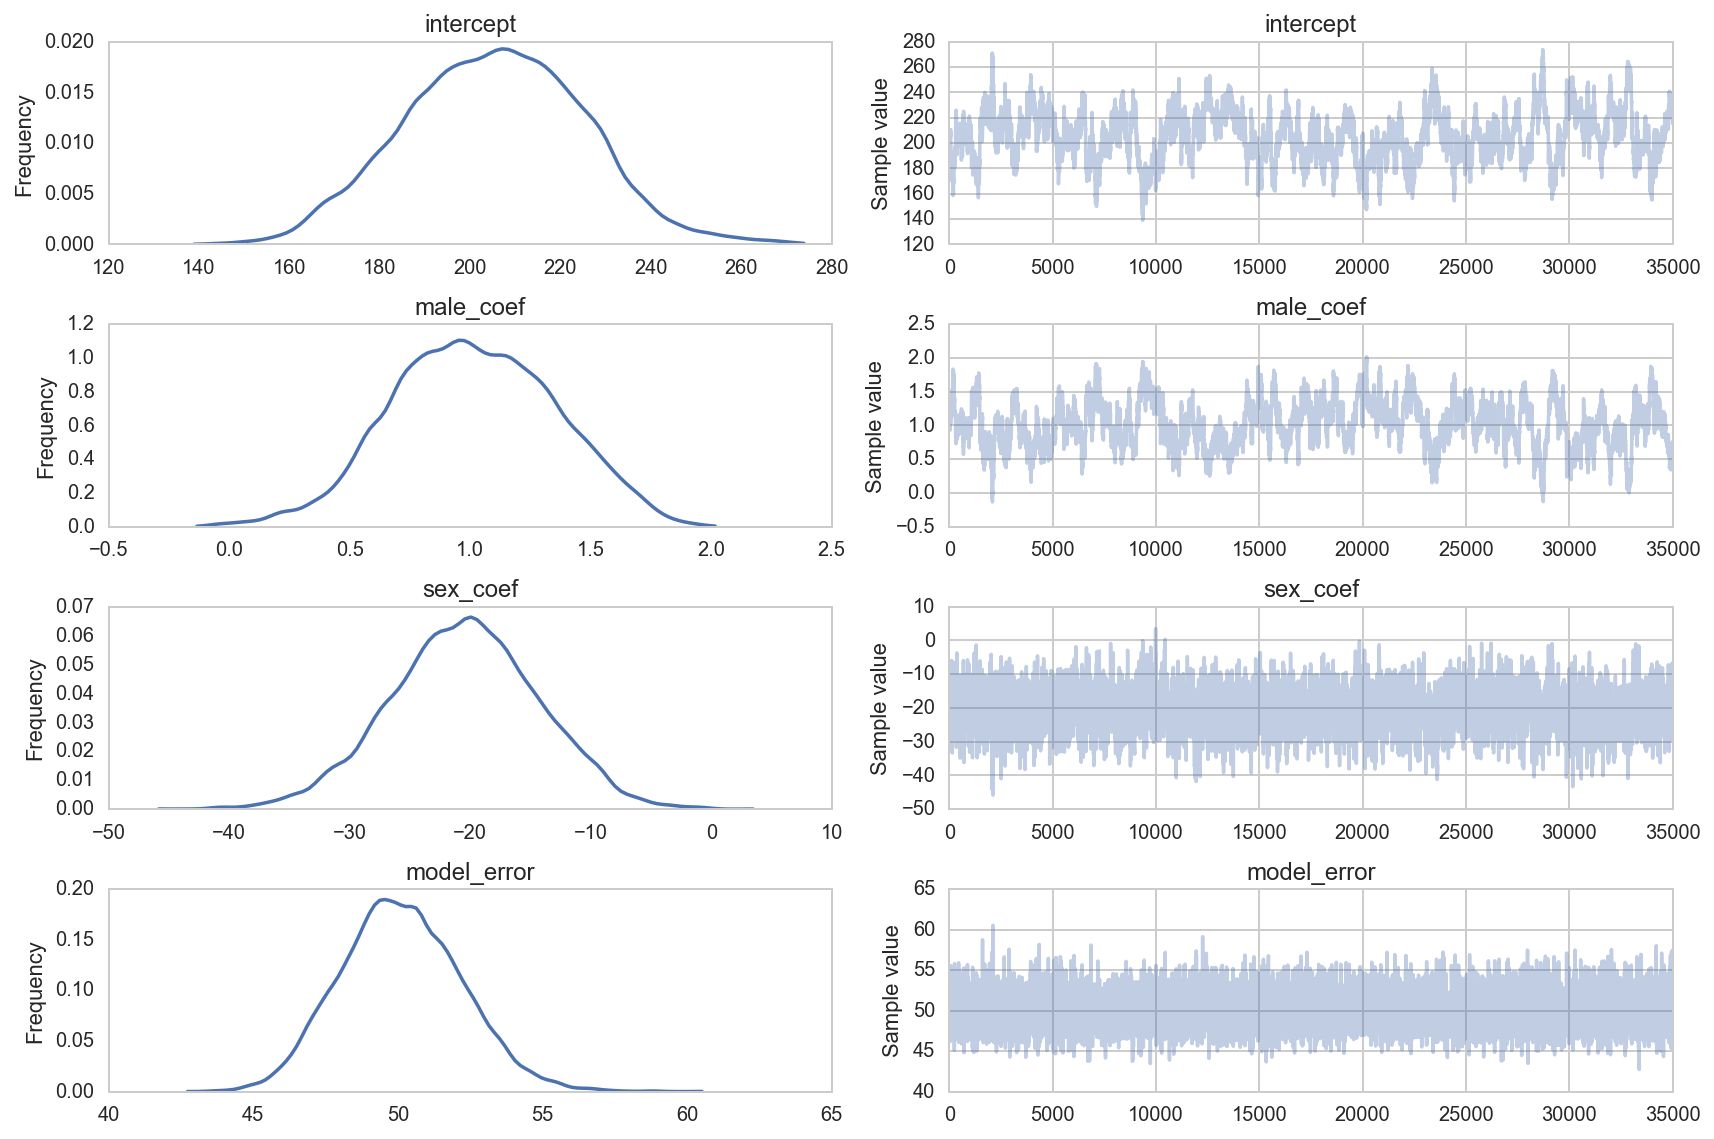

In [83]:
pm.traceplot(trace[15000:])

(array([  3.,   9.,  19.,  53.,  55.,  51.,  42.,  27.,  25.,  11.,   3.,
          0.,   3.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 126. ,  147.9,  169.8,  191.7,  213.6,  235.5,  257.4,  279.3,
         301.2,  323.1,  345. ,  366.9,  388.8,  410.7,  432.6,  454.5,
         476.4,  498.3,  520.2,  542.1,  564. ]),
 <a list of 20 Patch objects>)

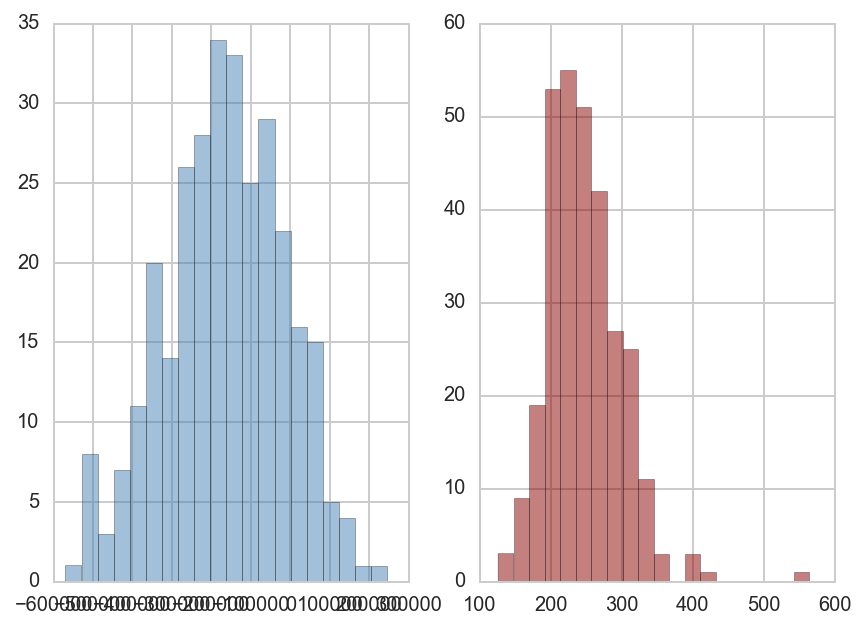

In [84]:
ppc = pm.sample_ppc(chol_trace[50000:], samples = 10, model = chol_manual)
ppc['chol_like'].shape
y_hat = np.mean(ppc['chol_like'],axis=0)

fig, ax = plt.subplots(1,2,figsize=(7,5))
ax[0].hist(y_hat,bins=20,color='steelblue',alpha=0.5)
ax[1].hist(heart.chol.values,bins=20,color='darkred',alpha=0.5)

In [85]:
#mode l age by gender
# sklearn.chol ~ intercept + age = gender + age:gender 
# 

In [95]:
with pm.Model() as age_by_gender:
    intercept = pm.Normal('intercept', mu=0, sd=1000.)
    female = pm.Normal('female',mu=0,sd=1000.)
    # going to model of age overall, and then between the two genders
    # for each gender we will have age slope, but this will come from the overall age
    
    overall_age_mean = pm.Normal('overall_age_mean',mu=0, sd=1000.)
    overall_age_sd = pm.Uniform('overall_age_sd', lower=0, upper = 10000.)
    
    #informed by previous belief overall
    age_by_gender_coefs = pm.Normal('age_by_gender'
                                    , mu=overall_age_mean
                                    ,sd=overall_age_sd
                                    , shape=len(heart.sex.unique()))
    
    chol_est = (intercept 
                + female*heart.sex.values 
                + age_by_gender_coefs[heart.sex.values] ) # 
    model_error = pm.Uniform('model_error',lower=0, upper = 10000)
    chol_like = pm.Normal('chol_like'
                          ,mu=chol_est
                          , sd=model_error
                          , observed= heart.chol.values )
    
    # heart.sex.values = [1,1,0,1]
    # age by gender coefs = [normal_males(), normal_females()]
    # age by gender coefs[heart.sex.values]
    # normal females, normal females, normal males, normal females] <=== mapped over like algebra
    
    # there's an overall impact of age
    # but underneath it affects female age, and male age
    # this is called a hierarchical model or mixed effects
    
    # another example is education ==> overall education, then state, then school, vs. homeschool, etc...
    # not completely siloed, but still distinct

Applied interval-transform to overall_age_sd and added transformed overall_age_sd_interval_ to model.
Applied interval-transform to model_error and added transformed model_error_interval_ to model.


In [96]:
with age_by_gender:
    step = pm.Metropolis()
    trace = pm.sample(50000,step)
    

 [-----------------100%-----------------] 50000 of 50000 complete in 24.9 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128e67e90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x122fc3910>]], dtype=object)

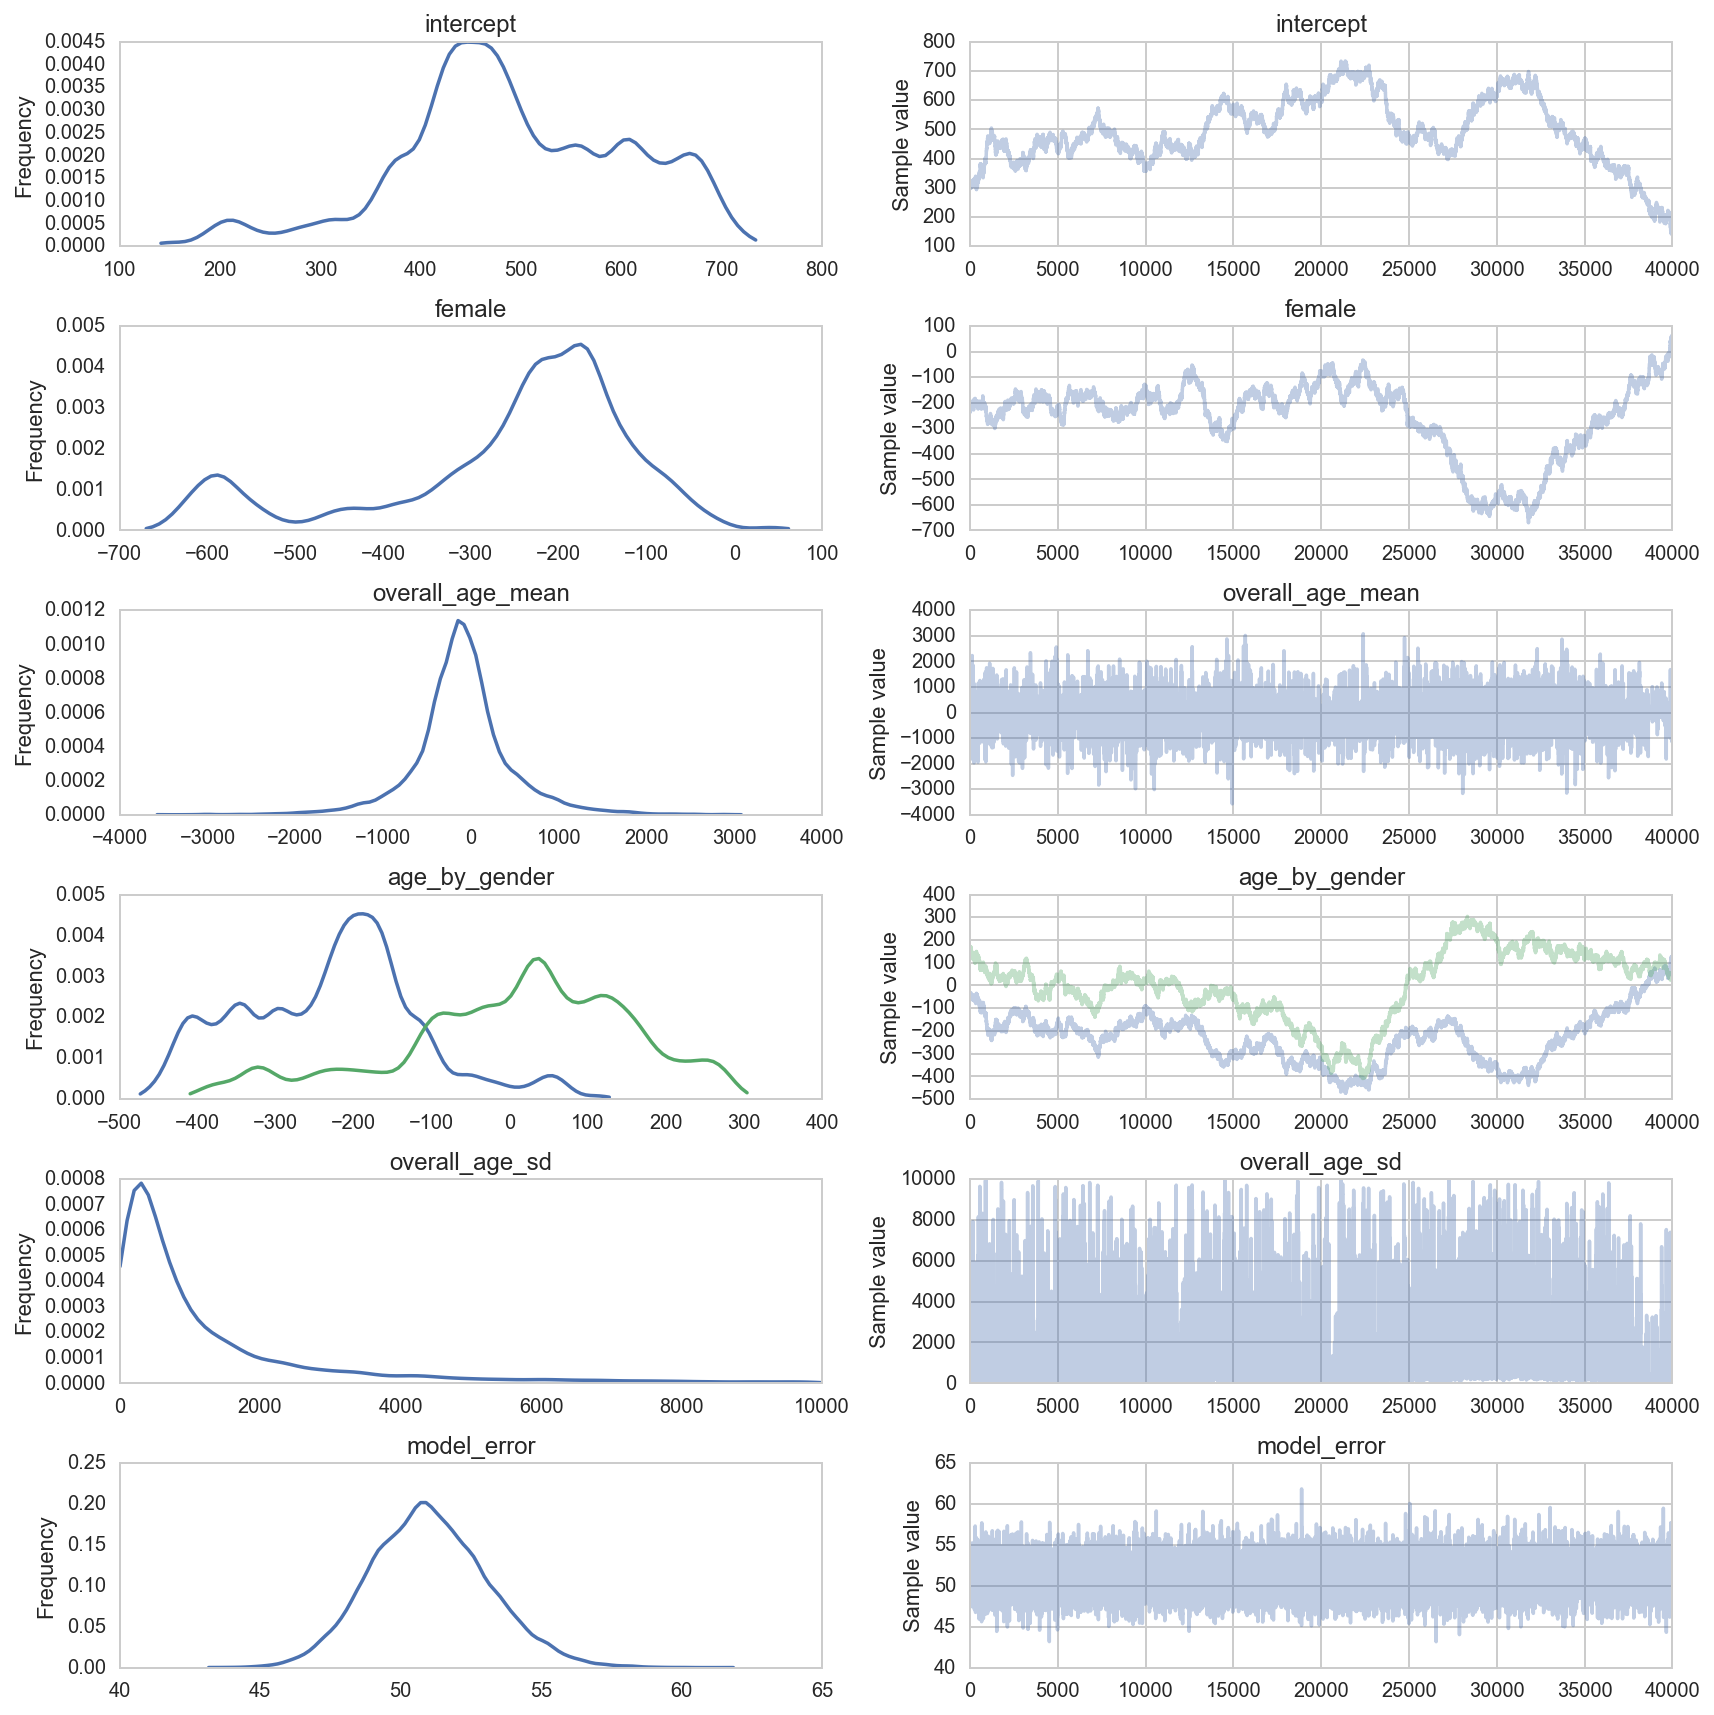

In [99]:
pm.traceplot(trace[10000:])

In [104]:
heart_females = heart[heart.sex==1].index
heart_males = heart[heart.sex==0].index
heart_mostly_female = heart.loc[heart_females | heart_males[0:10]]

print heart_females